In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'
import torch
from torch import nn
import torch.nn.functional as F

In [21]:
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
da = DihedralAdherence(
    'T1024', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], mode='kde_af',
    ml_lengths=[4096, 512, 256, 256], weights_file='ml_data/best_model_1.3k.pt', device='cuda')
da.load_results()
# da.compute_das(replace=True)

Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Win 4: VILL - 3558 samples
Win 5: LVILL - 203 samples
Win 6: LVILLL - 49 samples
Win 7: LLVILLL - 20 samples


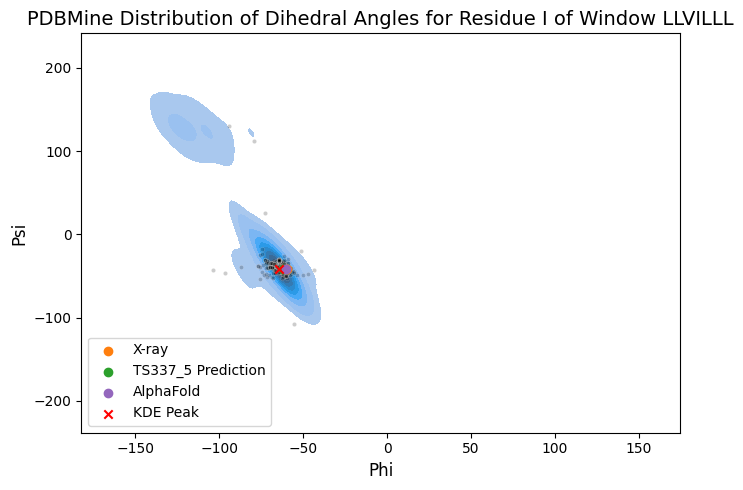

In [25]:
da.plot_one_dist()

               phi          psi       weight      winsize
count  2776.000000  2776.000000  2776.000000  2776.000000
mean    -84.862176    45.049964     2.496398     4.048271
std      43.706068    83.444210     6.645678     0.214377
min    -178.400000  -179.600000     1.000000     4.000000
25%    -115.700000   -39.700000     1.000000     4.000000
50%     -82.500000    52.400000     1.000000     4.000000
75%     -65.300000   127.625000     1.000000     4.000000
max     174.600000   178.600000    32.000000     5.000000
Residue Q of Window KNLQLRL centered at 11 of KNLQLRL
	Win 4: LQLR - 2642 samples
	Win 5: NLQLR - 134 samples
	Win 6: NLQLRL - 0 samples
	Win 7: KNLQLRL - 0 samples
Ideal:	 (-111.60, 144.80)
X-ray[11]:	 (-60.63, -41.58), DA=180.95
TS337_5[11]:	 (-63.65, -38.60), DA=182.99
AlphaFold[11]:	 (-59.06, -48.46), DA=174.82
Other Predictions DA:
                 0
count  463.000000
mean   177.280646
std     20.698030
min     24.117781
25%    178.865306
50%    181.201719
75%    183.2

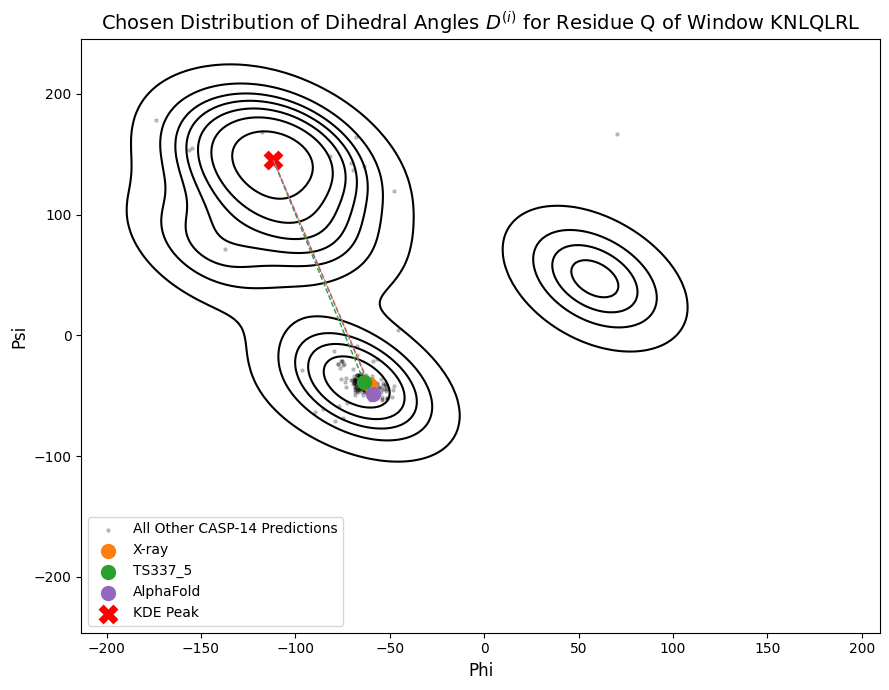

In [14]:
da.plot_da_for_seq('KNLQLRL')
# da.plot_one_dist_3d('VATFVAG')

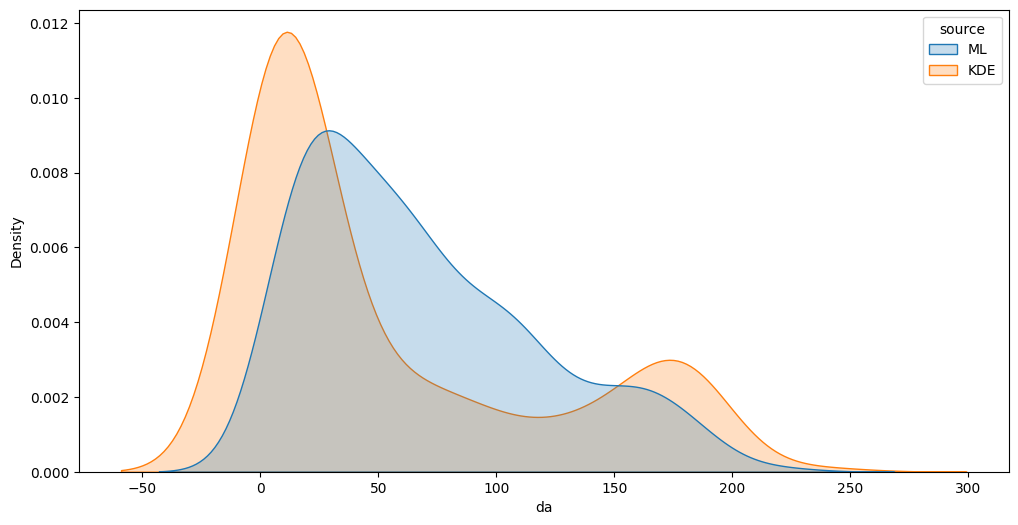

In [43]:
xray_phi_psi = pd.read_csv(da.outdir / 'xray_phi_psi_da_ml.csv')
xray_phi_psi['source'] = 'ML'
xray_phi_psi2 = pd.read_csv(da.outdir / 'xray_phi_psi_da.csv')
xray_phi_psi2['source'] = 'KDE'
df = pd.concat([xray_phi_psi, xray_phi_psi2], axis=0).reset_index(drop=True)
sns.set_palette('tab10')
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=df, x='da', fill=True, ax=ax, common_norm=False, hue='source')
plt.show()

0.002740893112266776 -19.082372965605185


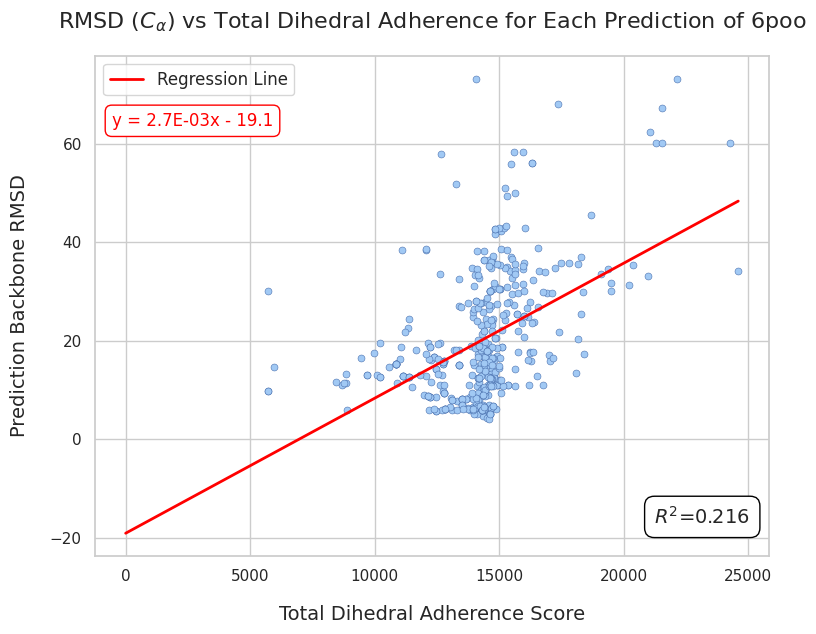

In [56]:
# da.load_results_da()
# da.plot_heatmap()
# da.plot_res_vs_da()
da.plot_da_vs_rmsd_simple()

In [1]:
from lib.utils import get_phi_psi_dist
from lib.ml.utils import get_ml_pred, load_model
from lib.ml.models import ModelWrapper
seq = da.overlapping_seqs[0]
seq = da.seqs[0]
phi_psi_dist = get_phi_psi_dist(da.queries, seq)[0]
res = da.get_center(seq)

ml = ModelWrapper([4096, 512, 256, 256])
ml.load('/home/musa/protein-dihedral-visualization/ml_data/best_model.pt')
ml_target = get_ml_pred(phi_psi_dist, da.winsizes, res, ml)

NameError: name 'da' is not defined

In [70]:
lengths = [4096, 512, 256, 256]
length = sum([l for l in lengths])
s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
device = 'cuda:0'
class LSTMNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.h = 32
        h = self.h
        nl = 1
        p_drop = 0.0
        mlp_h = 20
        self.lstm1 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        self.lstm2 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        self.lstm3 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        self.lstm4 = nn.LSTM(2, h, nl, batch_first=True, bidirectional=True, dropout=p_drop)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(h*8+20, mlp_h)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(mlp_h, 2)
    def forward(self, x, xres):
        x1 = x[:,:,s[0]:s[1]].permute(0,2,1)
        x2 = x[:,:,s[1]:s[2]].permute(0,2,1)
        x3 = x[:,:,s[2]:s[3]].permute(0,2,1)
        x4 = x[:,:,s[3]:    ].permute(0,2,1)
        x1 = self.lstm1(x1)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        x2 = self.lstm2(x2)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        x3 = self.lstm3(x3)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        x4 = self.lstm4(x4)[1][0].permute(1,0,2)[:,-2:,:].flatten(1)
        x = torch.cat([x1,x2,x3,x4], dim=1)
        x = torch.cat([x, xres], dim=1)
        x = self.dropout1(x)
        x = self.fc1(F.relu(x))
        x = self.dropout2(x)
        x = self.fc2(F.relu(x))
        return x    
model = (LSTMNet()).to(device)
model.load_state_dict(torch.load('ml_data/best_model_xres_h32_nl1_mlp20_dropout30_1.7k.pt'))

<All keys matched successfully>

In [ ]:
def plot(Xp, y, i, logits=None, logits2=None, res=None):
    ls = lengths
    Xp = Xp.cpu().clone().detach()
    y = y
    Xp[Xp==0] = np.nan
    s = [sum(lengths[:i]) for i,l in enumerate(ls)]
    s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
    plt.plot(Xp[i, 0, s[0]:s[1]], Xp[i, 1, s[0]:s[1]], 'o', label='4')
    plt.plot(Xp[i, 0, s[1]:s[2]], Xp[i, 1, s[1]:s[2]], 'o', label='5')
    plt.plot(Xp[i, 0, s[2]:s[3]], Xp[i, 1, s[2]:s[3]], 'o', label='6')
    plt.plot(Xp[i, 0, s[3]:    ], Xp[i, 1, s[3]:    ], 'o', label='7')
    
    plt.plot(y[i,0],y[i,1], 'X', label='true', color='purple',  markersize=10)
    if logits is not None:
        logits = logits.cpu().clone().detach()
        plt.plot(logits[i,0].detach(),logits[i,1].detach(), 'X', label='pred', color='black', markersize=10)
    if logits2 is not None:
        plt.plot(logits2[i,0],logits2[i,1], 'X', label='pred2', color='orange', markersize=10)
    plt.legend()

In [ ]:
from lib.utils import get_phi_psi_dist, find_kdepeak
from lib.constants import AMINO_ACID_MAP
i = 4
phi_psi = get_phi_psi_dist(da.queries, seqs[i])[0]
y = da.xray_phi_psi[da.xray_phi_psi.seq_ctxt == seqs[i]][['phi','psi']].values
X = []
kde = find_kdepeak(phi_psi, None)[['phi','psi']].values.reshape(1,-1)
for weight, l in zip([1,32,64,128], lengths):
    phi, psi = phi_psi[phi_psi.weight == weight][['phi','psi']].values.T
    if phi.shape[0] < l:
        phi = np.pad(phi, ((0,l-phi.shape[0])), mode='constant', constant_values=0)
        psi = np.pad(psi, ((0,l-psi.shape[0])), mode='constant', constant_values=0)
    else:
        phi = np.random.choice(phi, l, replace=False)
        psi = np.random.choice(psi, l, replace=False)
    X.append(np.stack([phi, psi]))
xres = F.one_hot(torch.Tensor([AMINO_ACID_MAP[da.get_center(seqs[i])]]).to(torch.int64), 20).to(device)
X = np.hstack(X)
X = torch.Tensor(X).unsqueeze(0).to(device)
logits = model(X, xres)
plot(X, y, 0, logits, kde)